In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import deque
import random
from tqdm import tqdm
from matplotlib import pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, action_size)

    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=-1, keepdim=True))
        return q_values

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

file_path = '/content/artists_output_with_top_tracks.csv'
data = pd.read_csv(file_path)

categorical_features = ['GenreID', 'ArtistID', 'TrackID', 'ExplicitLyrics', 'ExplicitContentLyrics', 'ExplicitContentCover']
numerical_features = ['Duration', 'Rank', 'BPM', 'Gain']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
data_transformed = preprocessing_pipeline.fit_transform(data)
data_transformed = torch.FloatTensor(data_transformed.toarray())

def get_action(state, model, epsilon=0.1):
    if random.random() < epsilon:  # Explore: select a random action
        return random.choice([0, 1])
    else:  # Exploit: select the action with the highest predicted reward
        with torch.no_grad():
            return model(state).argmax().item()

def get_reward(action, state):
    if action == 1:  # "Like"
        return random.choice([0, 1])
    else:
        return random.choice([-1, 0])

def train_dueling_dqn(model, target_model, buffer, data, original_data, episodes=30, batch_size=64, gamma=0.99, update_target_every=5):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    losses = []

    for i in range(batch_size):
        for j, state_tensor in tqdm(enumerate(data)):
            # print("DEBUG:::", original_data.iloc[j])

            row = original_data.iloc[j]

            state_tensor = state_tensor.to(device)
            action = get_action(state_tensor, model)

            if row['ArtistName'] == 'Kanye West':
                if action == 1:
                    reward = 1
                else:
                    reward = -1
            else:
                if action == 0:
                    reward = 1
                else:
                    reward = -1

            next_state_tensor = state_tensor
            done = True

            buffer.add(state_tensor, action, reward, next_state_tensor, done)

    for episode in tqdm(range(episodes), desc="Training episodes"):
        rewards = []
        for j, state_tensor in enumerate(data):
            # print("DEBUG:::", original_data.iloc[j])

            row = original_data.iloc[j]
            state_tensor = state_tensor.to(device)

            action = get_action(state_tensor, model)
            if row['ArtistName'] == 'Kanye West':
                if action == 1:
                    reward = 1
                else:
                    reward = -1
            else:
                if action == 0:
                    reward = 1
                else:
                    reward = -1

            next_state_tensor = state_tensor
            done = True

            buffer.add(state_tensor, action, reward, next_state_tensor, done)

            next_state_tensor = state_tensor
            done = True

            buffer.add(state_tensor, action, reward, next_state_tensor, done)

            if len(buffer) >= batch_size:
                batch = buffer.sample(batch_size)
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)

                states = torch.stack([s.clone().detach() for s in batch_states]).float().to(device)
                actions = torch.tensor(batch_actions).long().to(device)
                rewards = torch.tensor(batch_rewards).float().to(device)
                next_states = torch.stack([s.clone().detach() for s in batch_next_states]).float().to(device)
                dones = torch.tensor(batch_dones).float().to(device)

                max_next_q_values = target_model(next_states).max(1)[0]
                target_q_values = rewards + gamma * max_next_q_values * (1 - dones)
                current_q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                loss = loss_fn(current_q_values, target_q_values)
                losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if episode % update_target_every == 0:
                target_model.load_state_dict(model.state_dict())
    return losses

state_size = data_transformed.shape[1]
action_size = 2

model = DuelingDQN(state_size, action_size).to(device)
target_model = DuelingDQN(state_size, action_size).to(device)
target_model.load_state_dict(model.state_dict())
replay_buffer = ReplayBuffer(100)

losses = train_dueling_dqn(model, target_model, replay_buffer, data_transformed, data, episodes = 3)

6129it [00:04, 1407.33it/s]
6129it [00:03, 1822.30it/s]
6129it [00:03, 1801.12it/s]
6129it [00:03, 1556.96it/s]
6129it [00:03, 1597.40it/s]
6129it [00:03, 1834.54it/s]
6129it [00:03, 1826.33it/s]
6129it [00:04, 1388.35it/s]
6129it [00:03, 1549.79it/s]
6129it [00:03, 1833.81it/s]
6129it [00:03, 1697.21it/s]
6129it [00:04, 1451.99it/s]
6129it [00:03, 1822.67it/s]
6129it [00:03, 1836.34it/s]
6129it [00:04, 1488.60it/s]
6129it [00:03, 1563.69it/s]
6129it [00:03, 1814.35it/s]
6129it [00:03, 1734.24it/s]
6129it [00:04, 1339.27it/s]
6129it [00:03, 1857.67it/s]
6129it [00:03, 1785.42it/s]
6129it [00:03, 1798.51it/s]
6129it [00:04, 1390.75it/s]
6129it [00:03, 1814.37it/s]
6129it [00:03, 1852.81it/s]
6129it [00:03, 1640.79it/s]
6129it [00:03, 1535.53it/s]
6129it [00:03, 1818.17it/s]
6129it [00:04, 1364.09it/s]
6129it [00:04, 1373.22it/s]
6129it [00:03, 1851.66it/s]
6129it [00:03, 1859.70it/s]
6129it [00:03, 1717.99it/s]
6129it [00:04, 1408.57it/s]
6129it [00:03, 1853.83it/s]
6129it [00:03, 1786.

In [3]:
from IPython.display import display, Image, Audio, clear_output
import ipywidgets as widgets

def music_feedback_interface(image_url, sound_source):
    like_button = widgets.Button(description='Like', button_style='success')
    dislike_button = widgets.Button(description='Dislike', button_style='danger')
    display(Image(url=image_url, format='png', width=300, height=300))
    display(widgets.HBox([like_button, dislike_button]))

    def on_button_click(b):
        like_button.close()
        dislike_button.close()

        feedback = 1 if b.description == 'Like' else 0
        clear_output()

    like_button.on_click(on_button_click)
    dislike_button.on_click(on_button_click)

    display(Audio(url=sound_source, autoplay=True))

def recommend_song(model, data_transformed, original_data):
    max_q_value = -float('inf')
    max_q_value_index = None

    for i, state_tensor in enumerate(data_transformed):
        q_values = model(state_tensor.to(device)).detach().cpu().numpy()
        if q_values[1] > max_q_value:
            max_q_value = q_values[1]
            max_q_value_index = i
    return original_data.iloc[max_q_value_index]

recommended_song = recommend_song(model, data_transformed, data)

image_url = recommended_song["ImageLink"]
sound_source = recommended_song["Preview"]

music_feedback_interface(image_url,sound_source)

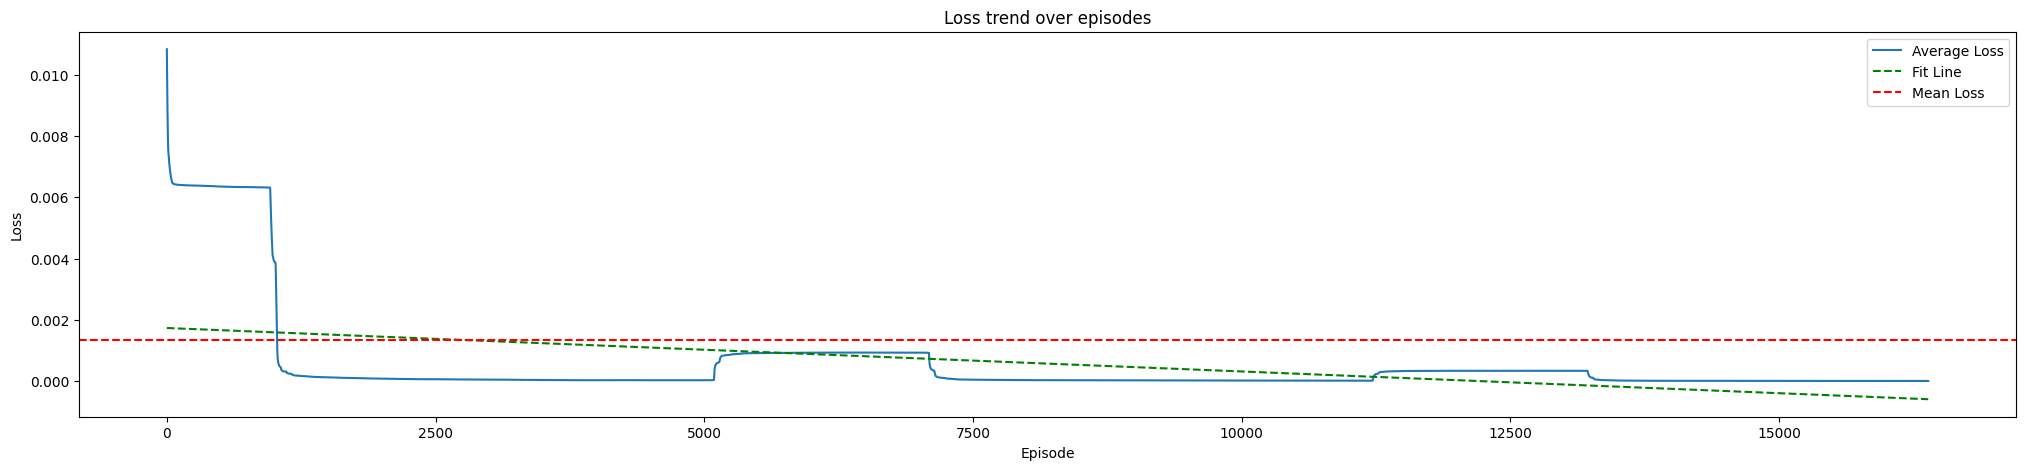

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

window_size = 2000
avg_losses = moving_average(losses, window_size)

coeffs = np.polyfit(range(len(avg_losses)), avg_losses, 1)

fit_line = coeffs[0] * np.array(range(len(avg_losses))) + coeffs[1]

mean_loss = np.mean(losses)

plt.figure(figsize=(25,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(fit_line, color='g', linestyle='--', label='Fit Line')
plt.axhline(mean_loss, color='r', linestyle='--', label='Mean Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss trend over episodes')
plt.legend()
plt.show()